# Vehicle Price Factor Analysis

## Table of Contents <a id='back'></a>

* [1. Introduction](#intro)
* [2. Import Libraries](#import)
* [3. Load Data](#load)
* [4. Data Overview](#review)
    * [4.1. Understanding Data](#overview)
	* [4.2. Data Cleaning](#clean)
		* [4.2.1. Invalid Data](#inv)
		* [4.2.2. Missing Data](#mis)
	* [4.3. Improve Data Quality](#imp)
	* [4.4. Check Cleaned Data](#check)
* [5. Analysis](#analysis)
	* [5.1. Study Core Parameters](#core)
	* [5.2. Handling Outliers](#outlier)
	* [5.3. Study Core Parameters Without Outliers](#nooutlier)
	* [5.4. Ads Days Listed](#days)
	* [5.5. Average Price by Type](#price)
	* [5.6. Price Factors](#pricef)
* [6. General Conclusion](#end)

## 1. Introduction <a id='intro'></a>

### 1.1. Project Description

You are an analyst at Crankshaft List. Hundreds of free vehicle advertisements are posted on your website every day. You need to study the dataset from the past few years and determine the factors that influence the price of a vehicle.

### 1.2. Objectives

The objectives for this project are:
* Study the dataset from the past few years and determine the factors that influence the price of a vehicle.
* Study how outliers affect the shape and readability of the histograms.
* Explain how long an ad is typically listed. Determine when an ad is considered to be listed for a short period of time and when it is listed for a very long time.
* Determine two types of vehicles with the highest number of ads.
* Determine the most influential factor on the vehicle price.

### 1.3. Data Description

Dataset consists of: 
- `price`
- `model_year`
- `model`
- `condition`
- `cylinders`
- `fuel` — gas, disel, dan lain-lain.
- `odometer` — jarak tempuh kendaraan saat iklan ditayangkan  
- `transmission`
- `paint_color`
- `is_4wd` — apakah kendaraan memiliki penggerak 4 roda (tipe Boolean)
- `date_posted` — tanggal iklan ditayangkan 
- `days_listed` — jumlah hari iklan ditayangkan hingga dihapus

### 1.4. Methodology

The steps taken in this research are:
1. Data Validation
2. Exploratory Data Analysis
3. Conclusion

[back to table of contents](#back)

## 2. Import Libraries <a id='import'></a>

In [1]:
# Muat semua library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

[back to table of contents](#back)

## 3. Load Data <a id='load'></a>

In [2]:
# Muat file data menjadi DataFrame
df= pd.read_csv('datasets/vehicles_us.csv')

[back to table of contents](#back)

## 4. Data Overview <a id='review'></a>

### 4.1. Understanding Data <a id='overview'></a>

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB
None


In [4]:
df.isna().sum()[df.isna().sum() > 0]

model_year      3619
cylinders       5260
odometer        7892
paint_color     9267
is_4wd         25953
dtype: int64

There are a lot of missing data.

In [5]:
#check is_4wd unique values
df['is_4wd'].unique()

array([ 1., nan])

Missing values in `is_4wd` column indicates not 4wd value.

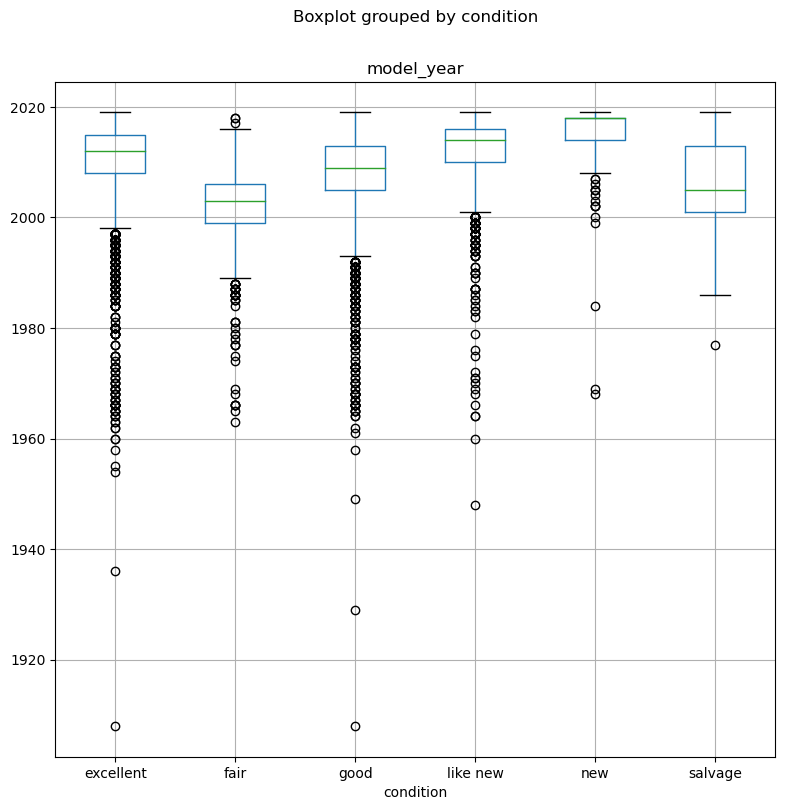

In [6]:
df.boxplot(column='model_year', by='condition', figsize=(9,9))
plt.title = 'Model_year grouped by Condition'
plt.show()

The distribution for model year seems to be increasing in this order: salvage; fair; good; excellent; like new; and new.

In [7]:
df.pivot_table(index=['model','transmission','cylinders'], values='price', aggfunc='count')

price
model             transmission cylinders       
acura tl          automatic    4.0            3
                               6.0          200
                  manual       6.0            8
bmw x5            automatic    6.0          196
                               8.0           48
...                                         ...
volkswagen passat automatic    5.0           42
                               6.0           26
                  manual       4.0            9
                               5.0            1
                               6.0            4

[536 rows x 1 columns]

From this table, we can see that we cannot generate missing price values based on these categories because of the variance.

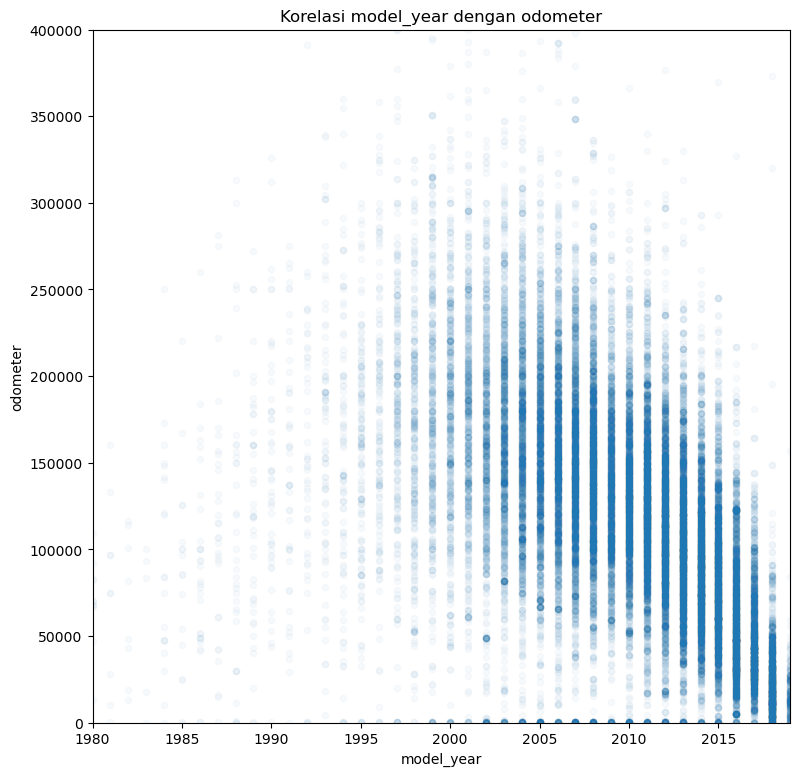

In [8]:
df.plot(x='model_year', y='odometer', kind='scatter', alpha=0.03, figsize=(9,9), title='Korelasi model_year dengan odometer', xlim=(1980,df['model_year'].max()), ylim=(0,400000))
plt.show()

In [9]:
print('Pearson correlation coefficient between model_year and odometer = {:.2f}'.format(df['model_year'].corr(df['odometer'])))

Pearson correlation coefficient between model_year and odometer = -0.47


There is a negative correlation between model year and odometer, we can use this to interpolate missing values in odometer.

In [10]:
df.sample(5)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
7311,11995,2016.0,honda civic,excellent,4.0,gas,88098.0,automatic,sedan,black,NaN,2018-09-20,96
6978,3100,2008.0,chevrolet impala,excellent,NaN,gas,129000.0,automatic,sedan,grey,NaN,2019-01-12,18
6429,5995,2012.0,chevrolet silverado 1500,like new,6.0,gas,101460.0,automatic,truck,NaN,NaN,2018-05-22,16
7094,12500,2015.0,ford escape,excellent,4.0,gas,NaN,automatic,SUV,silver,NaN,2019-02-16,8
49275,19995,2016.0,gmc sierra 1500,good,NaN,gas,123000.0,automatic,pickup,NaN,1.0,2018-09-16,109


Based on the general information and sample data above, there are several columns with missing values, incorrect data types, and values that do not match the column.

There are several columns with incorrect values, namely the `is_4wd` and `date_posted` columns.

There are also missing values in several columns such as `model_year, cylinders, odometer, paint_color, and is_4wd`.

The steps to clean and tidy the data are as follows: changing incorrect data types, removing duplicates, filling/removing rows with missing values, and modifying incorrect values such as values in the price column.

[back to table of contents](#back)

### 4.2. Data Cleaning <a id='clean'></a>

#### 4.2.1. Handling Invalid Data <a id='inv'></a>

In [18]:
df[['model_year','cylinders','days_listed']] = df[['model_year','cylinders','days_listed']].astype('int16')
df['is_4wd'] = df['is_4wd'].astype('bool')
df['date_posted'] = pd.to_datetime(df['date_posted'], format='%Y-%m-%d')

#### 4.2.2. Handling Missing Values <a id='mis'></a>

In [11]:
#calculate percentage of missing values
df.isna().sum()[df.isna().sum() > 0] / len(df)

model_year     0.070238
cylinders      0.102086
odometer       0.153168
paint_color    0.179854
is_4wd         0.503697
dtype: float64

In [12]:
grouped_by_model = df.groupby('model').agg({'model_year':'median','cylinders':'median'})

In [13]:
# handling missing values in model_year
for model in df['model'].unique():
    df.loc[(df['model']==model) & (df['model_year'].isna()),'model_year'] = \
    grouped_by_model.loc[(grouped_by_model.index==model),'model_year'][0]

In [14]:
# handling missing values in cylinders
for model in df['model'].unique():
    df.loc[(df['model']==model) & (df['cylinders'].isna()),'cylinders'] = \
    grouped_by_model.loc[(grouped_by_model.index==model),'cylinders'][0]

In [15]:
# handling missing values in odometer with simple linear regression
df_clean = df.dropna(subset=['model_year','odometer'])
df_standardized_manual = (df_clean - df_clean.mean()) / df_clean.std(ddof=0)
X = df_standardized_manual['model_year'].values.reshape(-1,1)
Y = df_standardized_manual['odometer'].values.reshape(-1,1)
reg = LinearRegression()
reg.fit(X,Y)
df['odometer_pred'] = reg.predict((df['model_year'].values.reshape(-1, 1) - df_clean['model_year'].mean())\
/df_clean['model_year'].std(ddof=0)).flatten() * df_clean['odometer'].std(ddof=0) + df_clean['odometer'].mean()

df['odometer'] = df['odometer'].combine_first(df['odometer_pred'])
df = df.drop(columns=['odometer_pred'])

C:\Users\Anglo\AppData\Local\Temp\ipykernel_17064\1576548554.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_standardized_manual = (df_clean - df_clean.mean()) / df_clean.std(ddof=0)


In [16]:
# handling missing values in paint_color
df['paint_color'].fillna(value='unidentified',inplace=True)

In [17]:
# handling missing values in is_4wd
df['is_4wd'].fillna(0,inplace=True)

### 4.3. Improve Data Quality <a id='imp'></a>

In [19]:
# Add day month and year posted
df['day_posted'] = df['date_posted'].dt.day.astype('int')
df['month_posted'] = df['date_posted'].dt.month.astype('int')
df['year_posted'] = df['date_posted'].dt.year.astype('int')

In [20]:
# Add age when the ads is published
df['age'] = df['year_posted'] - df['model_year']

In [21]:
# Add average distance per year variable
df['age'] = df['age'].replace(0,1)
df['avg_dist_per_yr'] = df['odometer']/df['age']

In [22]:
# label encoding for condition
dict_condition = {'salvage':0,'fair':1,'good':2,'excellent':3,'like new':4,'new':5}
df['condition'] = df['condition'].replace(dict_condition)

### 4.4. Check Cleaned Data <a id='check'></a>

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   price            51525 non-null  int64         
 1   model_year       51525 non-null  int16         
 2   model            51525 non-null  object        
 3   condition        51525 non-null  int64         
 4   cylinders        51525 non-null  int16         
 5   fuel             51525 non-null  object        
 6   odometer         51525 non-null  float64       
 7   transmission     51525 non-null  object        
 8   type             51525 non-null  object        
 9   paint_color      51525 non-null  object        
 10  is_4wd           51525 non-null  bool          
 11  date_posted      51525 non-null  datetime64[ns]
 12  days_listed      51525 non-null  int16         
 13  day_posted       51525 non-null  int32         
 14  month_posted     51525 non-null  int32

In [24]:
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

In [25]:
df.sample(5)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,day_posted,month_posted,year_posted,age,avg_dist_per_yr
19605,4900,2012,chevrolet equinox,2,4,gas,189456.0,automatic,SUV,unidentified,True,2018-10-12,5,12,10,2018,6,31576.000000
51035,19300,2014,ford f350,3,8,gas,204293.0,automatic,truck,white,True,2018-10-29,15,29,10,2018,4,51073.250000
11377,23000,2003,ford f150,3,8,gas,103000.0,automatic,truck,black,False,2018-06-28,94,28,6,2018,15,6866.666667
2269,17995,2016,ram 1500,2,8,gas,90542.0,automatic,truck,unidentified,True,2019-01-23,39,23,1,2019,3,30180.666667
1831,5999,2007,subaru outback,4,4,gas,164000.0,automatic,wagon,green,True,2019-03-09,11,9,3,2019,12,13666.666667


[back to table of contents](#back)

## 5. Analysis <a id='analysis'></a>

### 5.1. Study Core Parameters <a id='core'></a>

The primary parameters are:
- Price
- Age
- Distance
- Cylinders
- Condition

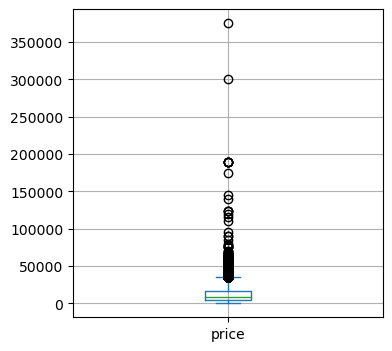

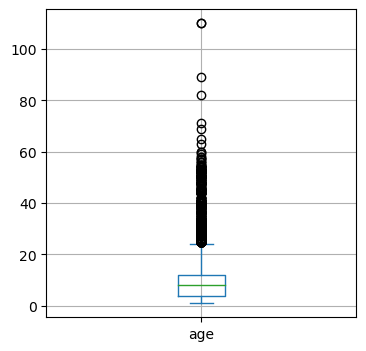

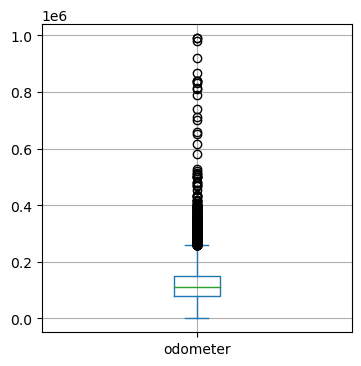

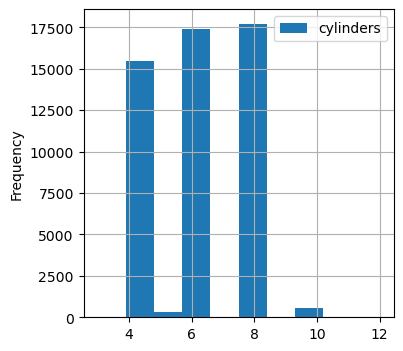

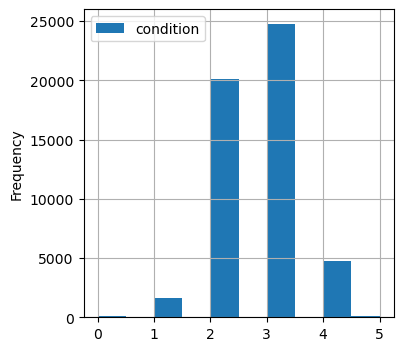

In [26]:
features=['price','age','odometer','cylinders','condition']

for i in range(len(features)):
    if i < 3:
        df.plot(y=features[i],kind='box',grid=True,figsize=(4,4))
        plt.show()
    else:
        df.plot(y=features[i],kind='hist',grid=True,figsize=(4,4))
        plt.show()

### 5.2. Handling Outliers <a id='outlier'></a>

In [27]:
columns = ['price','age','odometer']
lower_bound = df[columns].quantile(0.25) - 1.5*(df[columns].quantile(0.75)-df[columns].quantile(0.25))
upper_bound = df[columns].quantile(0.75) + 1.5*(df[columns].quantile(0.75)-df[columns].quantile(0.25))

In [28]:
lower_bound

price      -12758.5
age            -8.0
odometer   -31500.0
dtype: float64

In [29]:
upper_bound

price        34597.5
age             24.0
odometer    258900.0
dtype: float64

In [30]:
for i in range(3):
    if i == 0:
        df_no_outlier = df.query('@lower_bound[{}] <= {} <= @upper_bound[{}]'.format(i,columns[i],i))
    else:
        df_no_outlier = df_no_outlier.query('@lower_bound[{}] <= {} <= @upper_bound[{}]'.format(i,columns[i],i))   

### 5.3. Study Core Parameters Without Outliers <a id='nooutlier'></a>

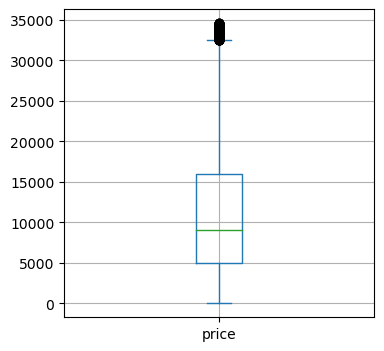

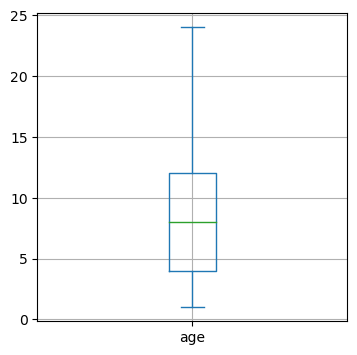

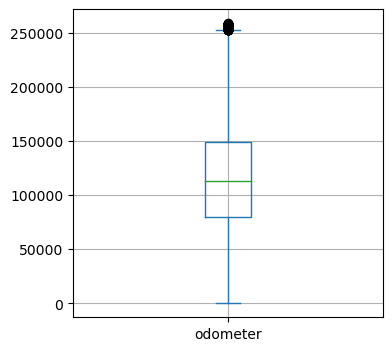

In [31]:
for i in range(len(columns)):
    if i < 3:
        df_no_outlier.plot(y=columns[i],kind='box',grid=True,figsize=(4,4))
        plt.show()

### 5.4. Ads Days Listed <a id='days'></a>

count    51525.00000
mean        39.55476
std         28.20427
min          0.00000
25%         19.00000
50%         33.00000
75%         53.00000
max        271.00000
Name: days_listed, dtype: float64


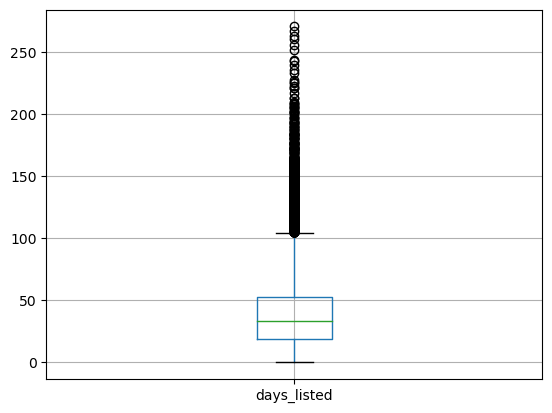

In [32]:
print(df['days_listed'].describe())
df.boxplot('days_listed')
plt.show()

On average, ads are displayed for 39.6 days.

The median value of days_listed is 33 days.

Ads are considered to be removed quickly if they are displayed for less than 19 days.

Ads are considered to be displayed for a very long time if they are displayed for more than 53 days.

### 5.5. Average Price by Type <a id='price'></a>

In [33]:
df_pivot = df.pivot_table(index=['type'],values=['price'],aggfunc=['count','mean'])
df_pivot.columns=['count','average']
df_pivot.sort_values(by=['count','average'],ascending=False,inplace=True)
df_pivot

,count,average
type,,
SUV,12405,11149.400000
truck,12353,16734.894924
sedan,12154,6965.358647
pickup,6988,16057.410418
coupe,2303,14353.442901
wagon,1541,9088.134328
mini-van,1161,8193.177433
hatchback,1047,6868.513849
van,633,10546.941548


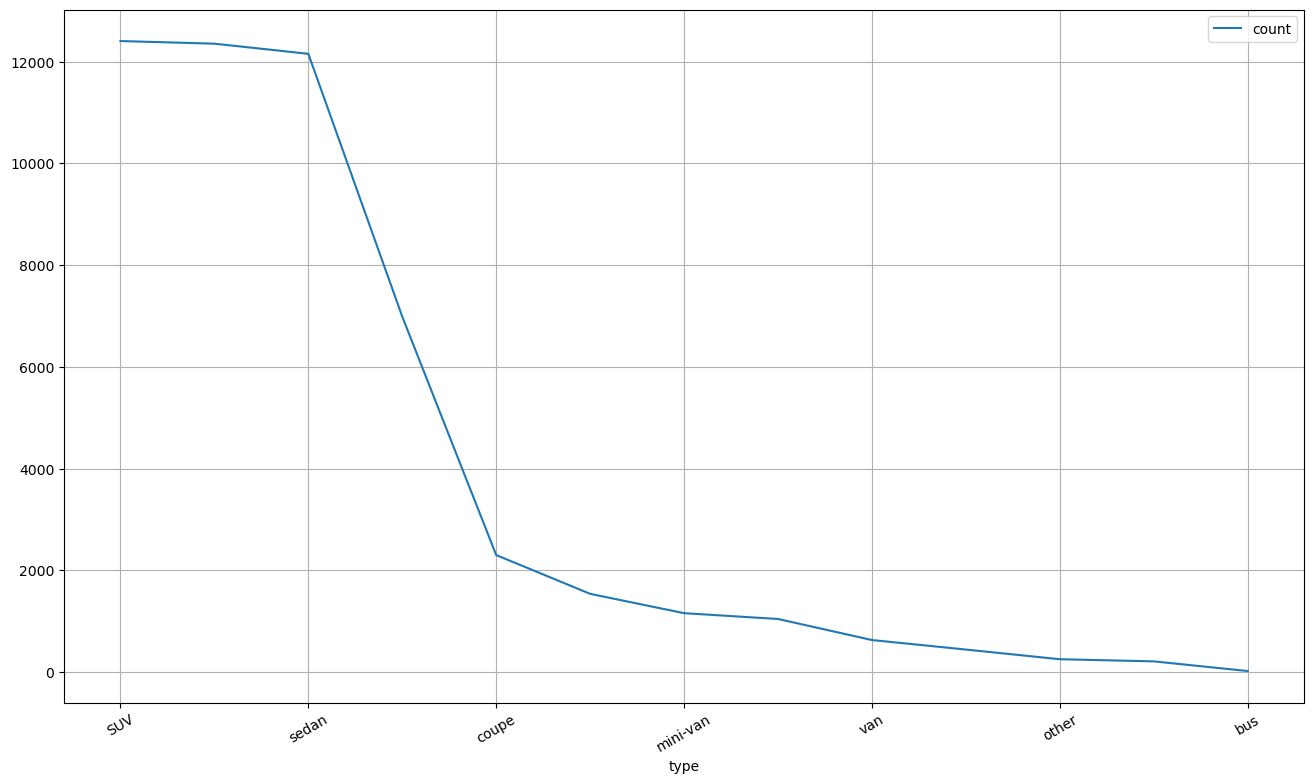

In [34]:
df_pivot.plot(use_index=True,y='count',figsize=(16,9),grid=True)
plt.xticks(rotation=30)
plt.show()

Vehicle type that has the most ads published is **SUV** followed by **truck**.

### 5.6. Price Factors <a id='pricef'></a>

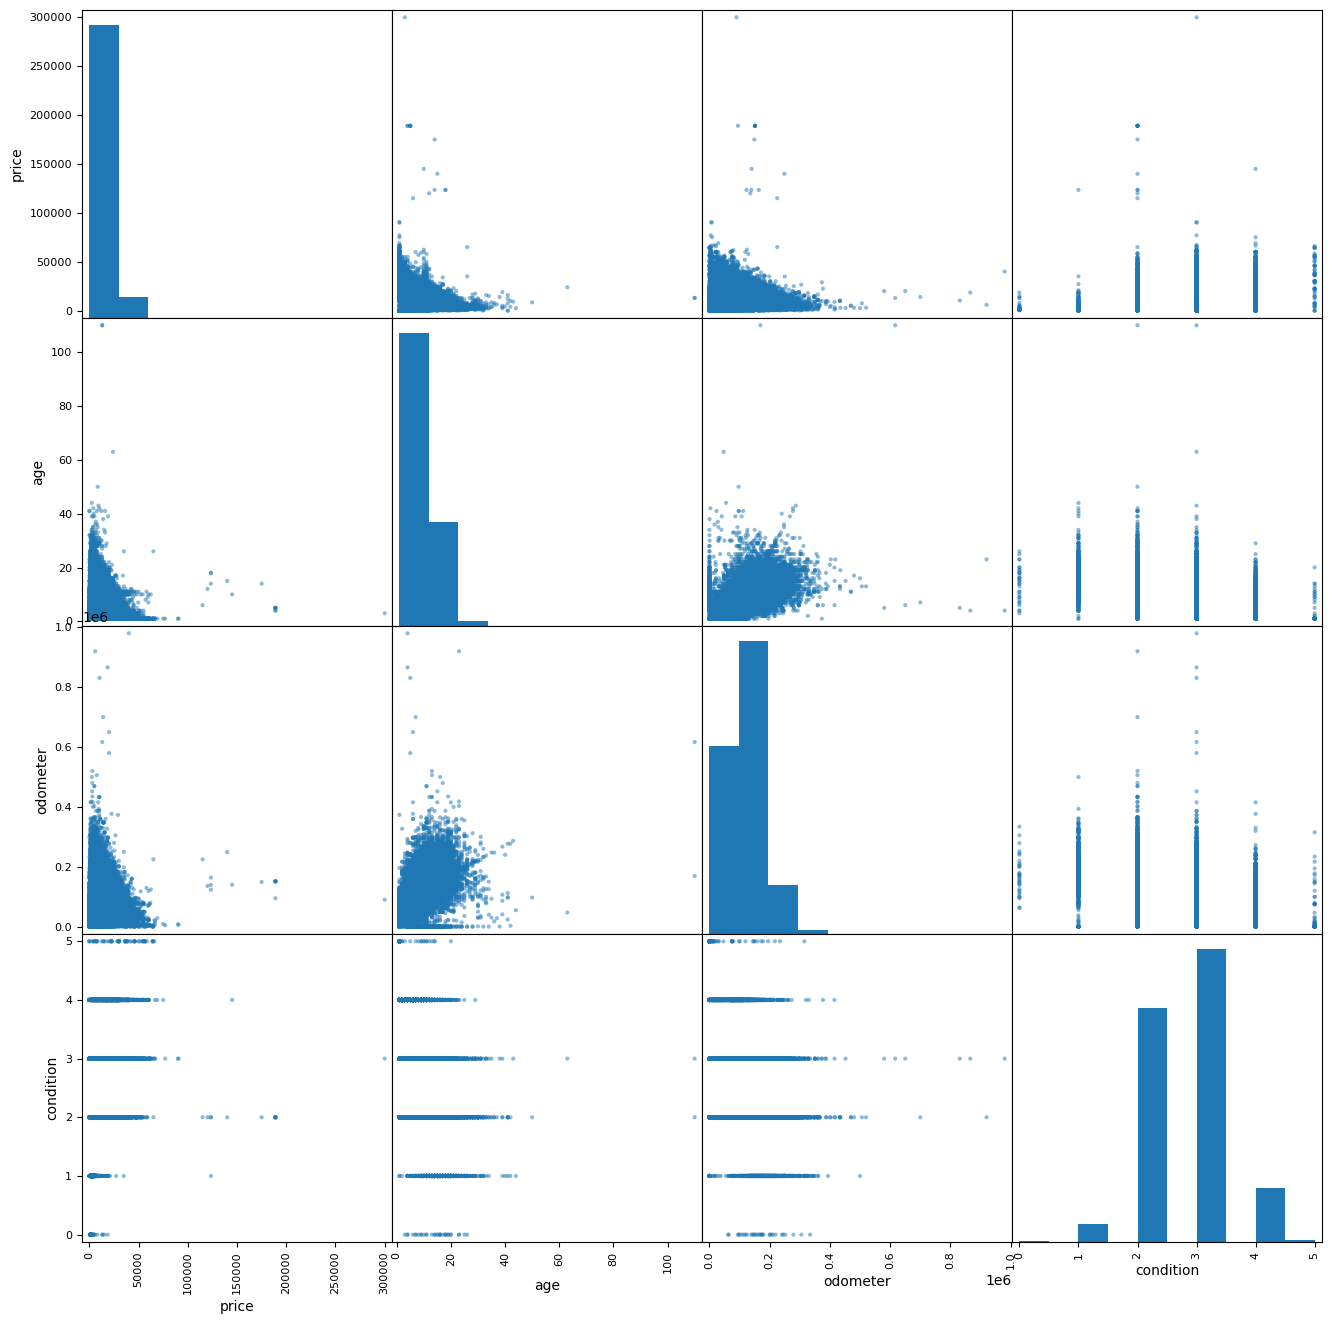

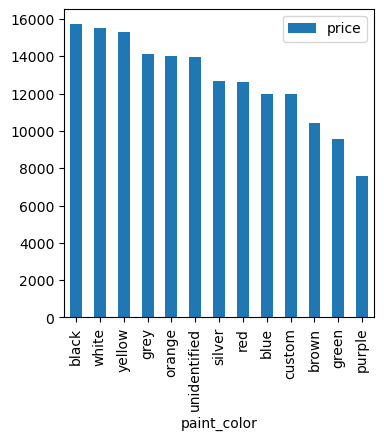

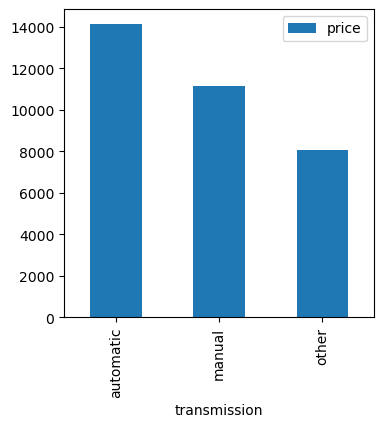

In [35]:
df_filtered = df[(df['type']=='SUV') | (df['type']=='truck')]
df_filtered

pd.plotting.scatter_matrix(df_filtered[['price','age','odometer','condition']],figsize=(16,16))
plt.show()

df_pivot_color = df_filtered.pivot_table(index='paint_color',values='price',aggfunc='mean')
df_pivot_color.sort_values(by='price',ascending=False).plot(kind='bar',figsize=(4,4))
plt.show()

df_pivot_transmission = df_filtered.pivot_table(index='transmission',values='price',aggfunc='mean')
df_pivot_transmission.sort_values(by='price',ascending=False).plot(kind='bar',figsize=(4,4))
plt.show()

It can be observed that there is a negative correlation between the variables age or odometer and price, where as the age or odometer increases, the price decreases. Based on the condition, it can also be seen that as the condition improves, the price increases, but this price difference is only significant for cars in salvage, fair, and good conditions. Other conditions do not significantly affect the car's price.

The most expensive color is black, followed by white, and the most expensive transmission type is automatic, followed by manual.

[back to table of contents](#back)

## 6. General Conclusion <a id='end'></a>

There are missing values in 5 columns: model_year, cylinders, odometer, paint_color, and is_4wd. The missing values in the model_year column are approximated by calculating them based on the car's condition because, when plotted with a box plot, these values can be approximated in this way. The missing values in the cylinders column are filled based on the car model because each car model has the same number of cylinders. Furthermore, the missing values in the odometer column are approximated based on the model year using linear regression because, when plotted with a scatter plot, a correlation of -0.4 between the two variables can be observed. The missing values in the paint_color column are filled with "unidentified" because the number of missing values in this column is very high (17%), and deleting them would affect the reliability of the analysis results. Lastly, after further investigation, it was found that the missing values in the is_4wd column were intentionally left blank. These missing values represent a binary value of 0 or False because the variable is actually a Boolean variable.

To improve the data quality, the researcher added the day_posted, month_posted, and year_posted columns, which were extracted from the date_posted variable. The year_posted column was then used to calculate the age of the posted car by subtracting the model_year from year_posted. Additionally, the researcher added the avg_dist_per_yr variable to calculate the average distance traveled per year. The condition variable was also recoded from categorical to numerical values to facilitate analysis.

The cleaned data was then studied using simple graphs. From the resulting box plots, it can be observed that there are outliers in the price, age, and odometer variables. These outliers would affect the analysis, so they were removed based on the lower and upper limits for each variable, determined using the formula Q1-1.5IQR and Q3+1.5IQR.

Next, the researcher analyzed the days_listed variable to determine the average listing duration and to identify when listings were considered to be removed too quickly or displayed for too long. On average, ads were displayed for 39.6 days, with a median duration of 33 days. Ads were considered to be removed too quickly if they were displayed for less than 19 days, and they were considered to be displayed for too long if they were displayed for more than 53 days. The research findings also revealed that the vehicle types with the highest number of ads were SUVs and trucks. It can be observed that there is a negative correlation between the variables age or odometer and price, where an increase in age or odometer leads to a decrease in price. Based on the condition variable, it can be seen that as the condition improves, the price also increases. The most expensive colors are black, followed by white, and the most expensive transmission type is automatic, followed by manual.

[back to table of contents](#back)